In [299]:
import numpy as np
import pandas as pd
import tensorflow as tf

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [2]:
df = zillow.LoadTabularData("data/")

In [3]:
zillow.LoadImageDataIntoDataFrame(df, "data/")

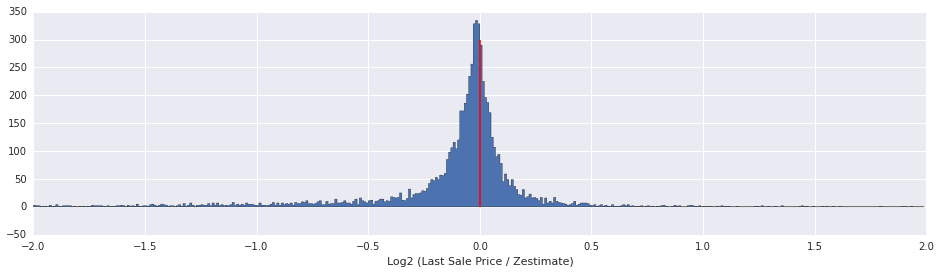

In [5]:
figsize(16, 4)
plt.hist(df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01), histtype="stepfilled")
plt.vlines(0, 0, 300, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

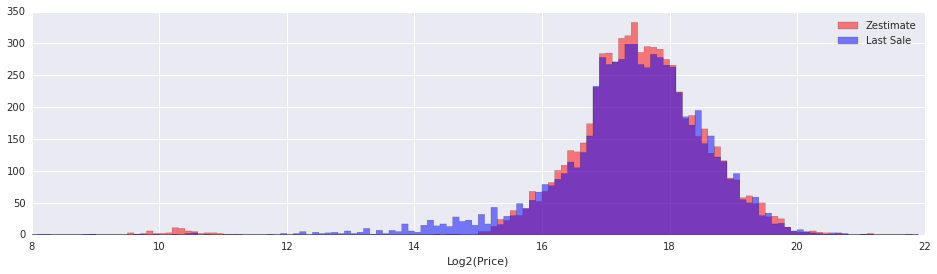

In [6]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

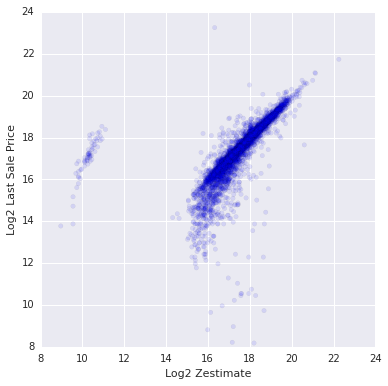

In [80]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.1)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

# Prepare Data for Training

In [8]:
regions = df.city + df.state
region_encoder = dict((r, n) for n, r in enumerate(regions.unique()))
df["region_code"] = regions.map(lambda r: region_encoder[r])

In [9]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Build a network in Keras

In [11]:
from keras import models, layers, optimizers, backend

In [69]:
def ConvolutionalRegressor(n_regions):
    # Convolutional portion
    img_model = models.Sequential()

    img_model.add(layers.Conv2D(32, 5, 5, border_mode="same", input_shape=(128, 128, 3)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(48, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(64, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(96, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))

    img_model.add(layers.Conv2D(128, 3, 3, border_mode="same"))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    img_model.add(layers.pooling.MaxPooling2D(pool_size=(2, 2)))
    
    img_model.add(layers.Conv2D(32, 4, 4, border_mode="valid"))
    img_model.add(layers.Reshape((32,)))
    img_model.add(layers.BatchNormalization())
    img_model.add(layers.LeakyReLU(0.2))
    
    # Embedding portion for region
    embed_model = models.Sequential()
    embed_model.add(layers.embeddings.Embedding(n_regions, 16, input_length=1))
    embed_model.add(layers.Reshape((16,)))
    img_model.add(layers.Dropout(0.5))
    
    # Merge
    merged = layers.Merge([img_model, embed_model], mode="concat")
    merged_model = models.Sequential()
    merged_model.add(merged)
    merged_model.add(layers.Dense(10))
    merged_model.add(layers.BatchNormalization())
    merged_model.add(layers.LeakyReLU(0.2))
    merged_model.add(layers.Dense(1))

    return merged_model

In [70]:
cr = ConvolutionalRegressor(max(region_encoder.values()) + 1)

In [71]:
cr.compile(optimizer="adam", loss="mse")

In [72]:
cr_history = cr.fit(
    [np.array(train_df.image.tolist()), np.array(train_df.region_code)],
    np.array(np.log2(train_df.last_sold)),
    batch_size=16,
    nb_epoch=5,
    verbose=1,
    validation_data=(
        [np.array(test_df.image.tolist()), np.array(test_df.region_code)],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True)

Train on 6167 samples, validate on 685 samples
Epoch 1/5
6167/6167 [==============================] - 765s - loss: 264.9107 - val_loss: 209.9715
Epoch 2/5
6167/6167 [==============================] - 753s - loss: 127.5029 - val_loss: 56.8802
Epoch 3/5
6167/6167 [==============================] - 747s - loss: 25.2912 - val_loss: 9.2022
Epoch 4/5
6167/6167 [==============================] - 747s - loss: 4.2473 - val_loss: 2.8893
Epoch 5/5
6167/6167 [==============================] - 769s - loss: 2.9137 - val_loss: 2.0545


In [74]:
df["predictions"] = cr.predict(
    [np.array(df.image.tolist()), np.array(df.region_code)],
    verbose=1)

6852/6852 [==============================] - 344s   


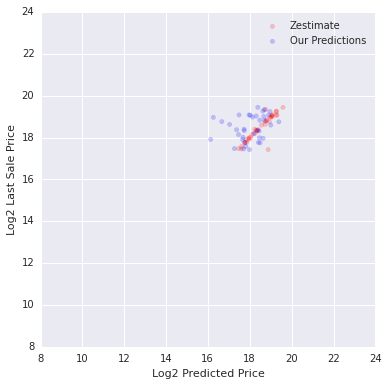

In [115]:
test_df.loc[test_ixs, "predictions"] = df.iloc[test_ixs].predictions
target_df = test_df

figsize(6, 6)
plt.scatter(
    np.log2(target_df.zestimate), np.log2(target_df.last_sold),
    alpha=0.2, color="red", label="Zestimate")
plt.scatter(
    target_df.predictions, np.log2(target_df.last_sold),
    alpha=0.2, color="blue", label="Our Predictions")
plt.xlabel("Log2 Predicted Price")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend()
plt.show()